# ART - Adversarial Patch - PyTorch - YOLO v5

In [1]:
import warnings
warnings.filterwarnings('ignore')

import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd

import yolov5
from yolov5.utils.loss import ComputeLoss

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import AdversarialPatchPyTorch

import cv2
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
%matplotlib inline

set ART_DATA_PATH to /Users/kieranfraser/.art/data


# Helper functions and Labels

In [2]:
COCO_CATEGORIES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

def extract_predictions(predictions_):
    # Get the predicted class
    predictions_class = [COCO_CATEGORIES[i] for i in list(predictions_["labels"])]

    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])

    predictions_boxes = [[tuple([int (i) for i in t]) for t in r] for r in predictions_boxes]

    return predictions_class, predictions_boxes, predictions_class


def plot_image_with_boxes(img, boxes, pred_cls):
    text_size = 1
    text_th = 3
    rect_th = 3
    
    for i in range(len(boxes)):
        
        color = tuple([int(i) for i in list(np.random.choice(range(256), size=3))])
        
        # Draw Rectangle with the coordinates
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color=color, thickness=rect_th)

        # Write the prediction class
        cv2.putText(img, pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, color, thickness=text_th)

    plt.axis("off")
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()

# Attack Settings

In [3]:
rotation_max=22.5
scale_min=0.4
scale_max=1.0
learning_rate=5000.
batch_size=16
max_iter=50
patch_shape=(3, 640, 640)

# Model definition

In [4]:
class YoloV5(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.hyp = {'box': 0.05,
                           'obj': 1.0,
                           'cls': 0.5,
                           'anchor_t': 4.0,
                           'cls_pw': 1.0,
                           'obj_pw': 1.0,
                           'fl_gamma': 0.0
                         }
        self.compute_loss = ComputeLoss(self.model.model.model)

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model.model.model(x)
            loss, loss_items = self.compute_loss(outputs, targets)
            loss_components_dict = {"loss_total": loss}
            return loss_components_dict
        else:
            return self.model(x)

model = yolov5.load('yolov5s.pt')
model = YoloV5(model)

detector = PyTorchYolo(model=model,
                       device_type='cpu',
                       input_shape=(3, 640, 640),
                       clip_values=(0, 255), 
                       attack_losses=("loss_total",))

# Example images

In [5]:
response = requests.get('https://ultralytics.com/images/zidane.jpg')
image_zidane = np.asarray(Image.open(BytesIO(response.content)).resize((640, 640)))
image_zidane = image_zidane.transpose(2,0,1)
image_zidane = np.stack([image_zidane], axis=0).astype(np.float32) 
image_zidane = image_zidane.copy()

response = requests.get('https://farm5.staticflickr.com/4092/5049609764_d83c7ba9f5_z.jpg')
image_kitchen = np.asarray(Image.open(BytesIO(response.content)).resize((640, 640)))
image_kitchen = image_kitchen.transpose(2,0,1)
image_kitchen = np.stack([image_kitchen], axis=0).astype(np.float32) 
image_kitchen = image_kitchen.copy()

-------
Yolov5 predictions for original image:
     scores  labels
0  0.549008       0
1  0.491418       0
2  0.464569       0
3  0.380837       0
4  0.379329      27
5  0.349320      27
6  0.347771      27
7  0.330712      27
8  0.326465      27
9  0.321336      27


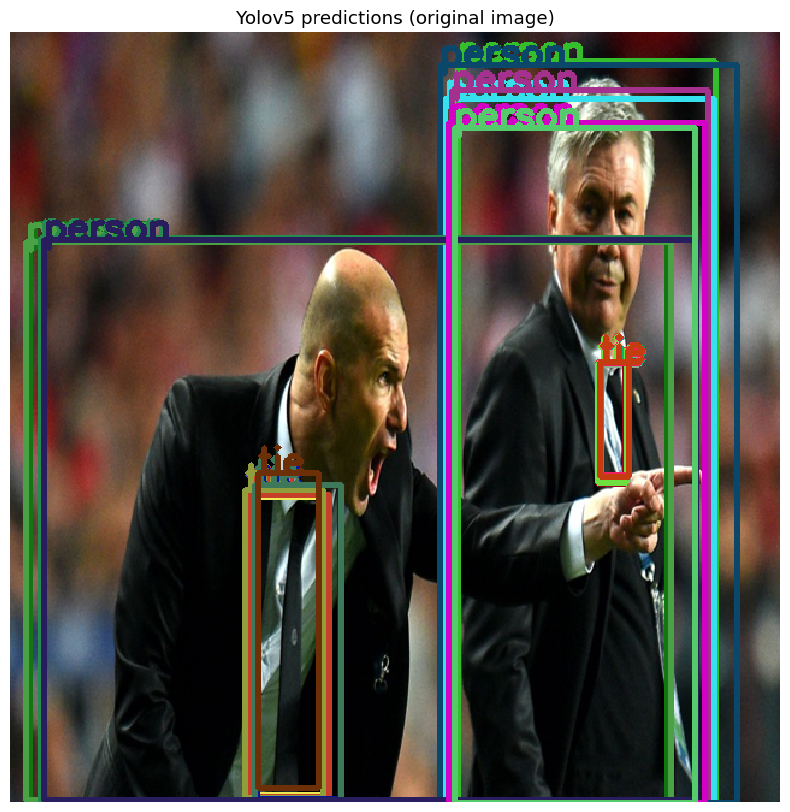

In [6]:
predictions = detector.predict(x=image_zidane)[0]


threshold = 0.2
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov5 predictions for original image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (original image)")
# Plot predictions
plot_image_with_boxes(img=image_zidane[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       

-------
Yolov5 predictions for original image:
     scores  labels
0  0.906055      72
1  0.901189      72
2  0.899998      72
3  0.896023      72
4  0.886083      72
5  0.878489      72
6  0.862562      56
7  0.855455      56
8  0.845125      72
9  0.834834      72


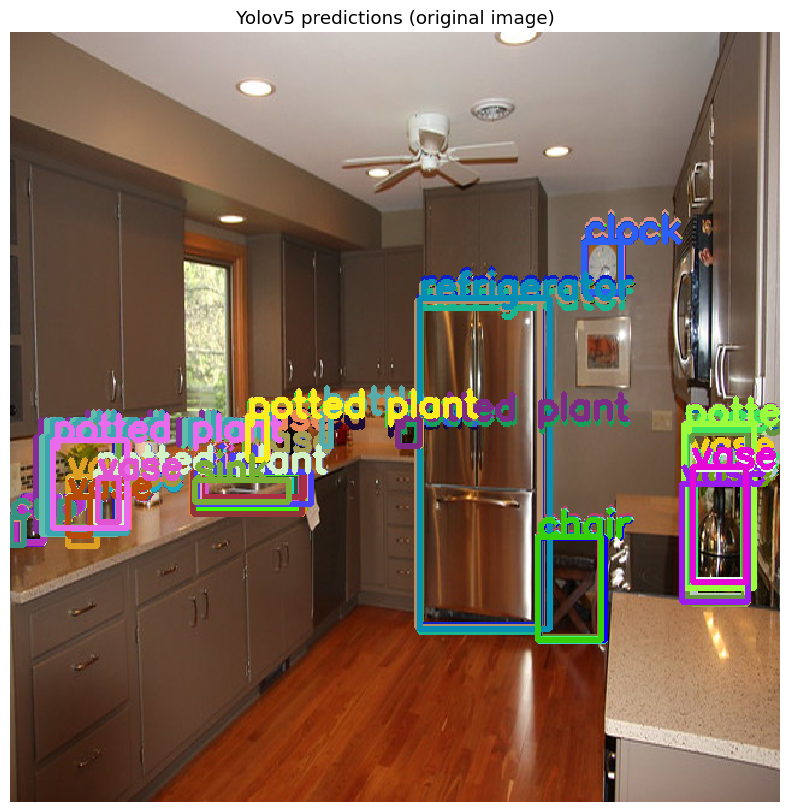

In [7]:
predictions = detector.predict(x=image_kitchen)[0]


threshold = 0.2
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov5 predictions for original image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (original image)")
# Plot predictions
plot_image_with_boxes(img=image_kitchen[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       

# Adversarial patch generation

In [19]:
target = detector.predict(image_zidane)

ap = AdversarialPatchPyTorch(
            estimator=detector,
            rotation_max=rotation_max,
            scale_min=scale_min,
            scale_max=scale_max,
            learning_rate=learning_rate,
            batch_size=batch_size,
            max_iter=max_iter,
            patch_shape=patch_shape,
            verbose=True,
        )

patch, patch_mask = ap.generate(x=image_zidane, y=target)

Adversarial Patch PyTorch:   0%|          | 0/50 [00:00<?, ?it/s]

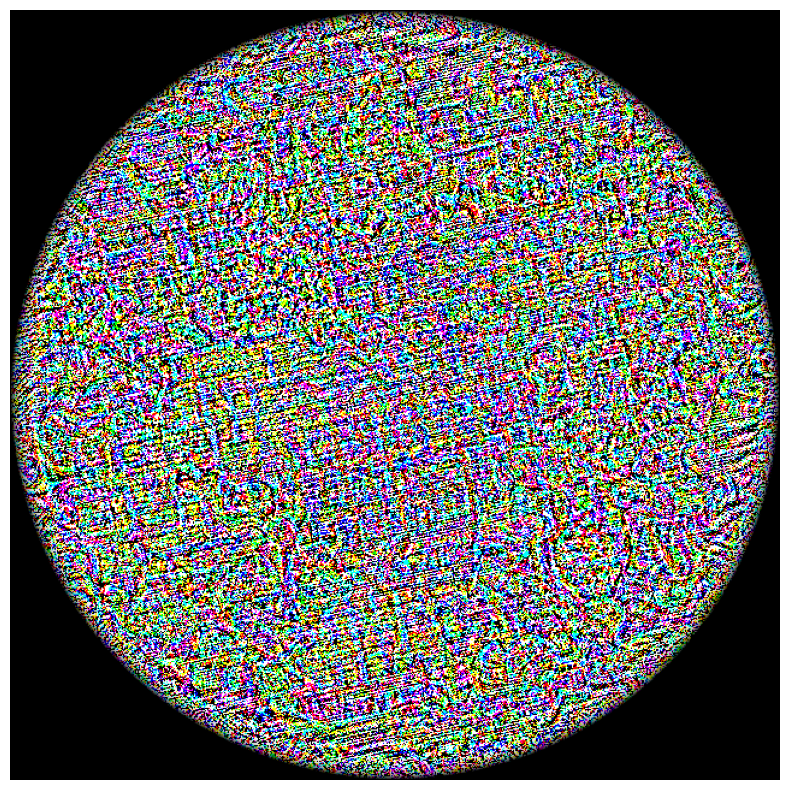

In [20]:
plt.axis("off")
plt.imshow((patch * patch_mask).transpose(1,2,0).astype(np.uint8))
plt.show()

# Evaluation

-------
Yolov5 predictions for malformed detector(?) on original image:
     scores  labels
0  0.005068      21
1  0.004421       0
2  0.003195      14
3  0.003164       0
4  0.003043      13
5  0.002927      13
6  0.002450       0
7  0.002133      14
8  0.002032      14
9  0.002011      13


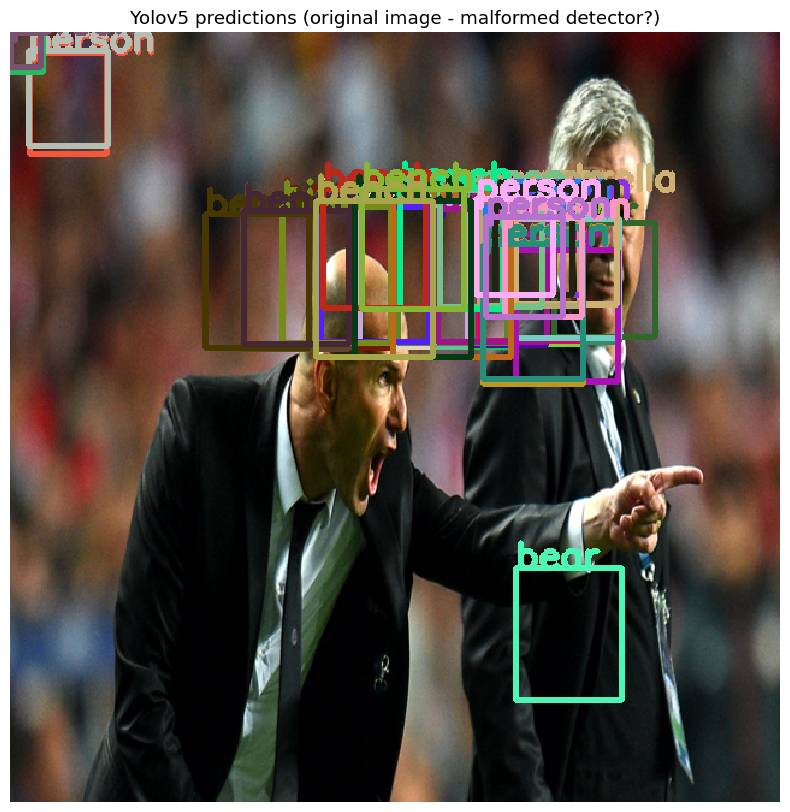

In [22]:
predictions = detector.predict(x=image_zidane)[0]


threshold = 0.0005
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov5 predictions for malformed detector(?) on original image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (original image - malformed detector?)")
# Plot predictions
plot_image_with_boxes(img=image_zidane[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       

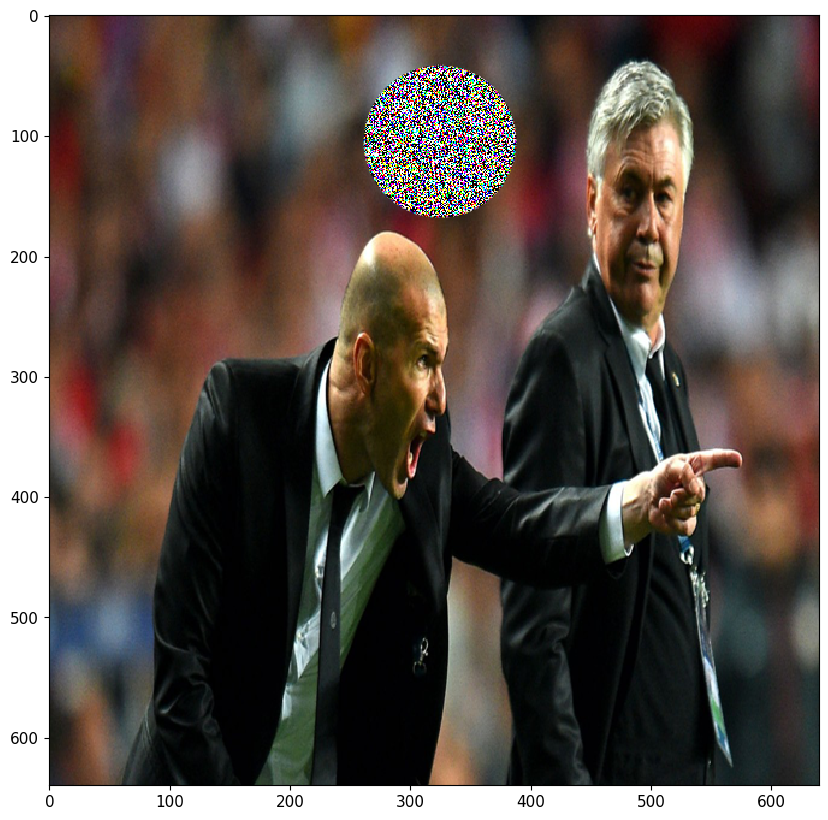

In [23]:
patched_image = ap.apply_patch(image_zidane, scale=0.2)
plt.imshow(patched_image[0].transpose(1,2,0).astype(np.uint8), interpolation="nearest")

-------
Yolov5 predictions for patched image:
     scores  labels
0  0.005093      21
1  0.004527       0
2  0.003486      14
3  0.003353      14
4  0.003349       0
5  0.003231      14
6  0.002451       0
7  0.002366      14
8  0.002274      14
9  0.002170      13


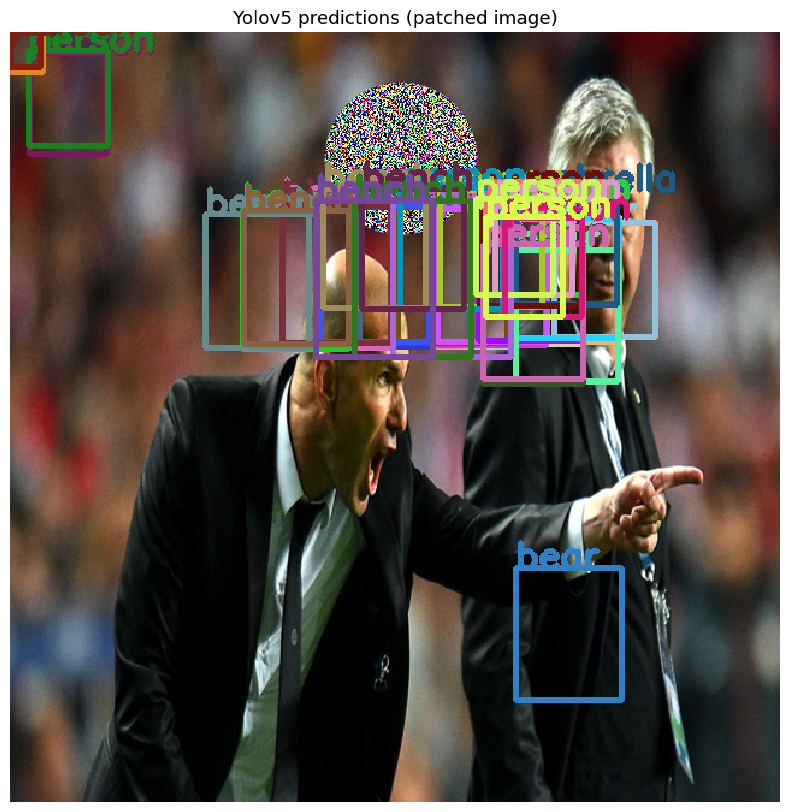

In [25]:
predictions = detector.predict(x=patched_image)[0]


threshold = 0.0005
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov5 predictions for patched image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (patched image)")
# Plot predictions
plot_image_with_boxes(img=patched_image[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       

### Evaluation on fresh detector

In [26]:
class YoloV5(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.hyp = {'box': 0.05,
                           'obj': 1.0,
                           'cls': 0.5,
                           'anchor_t': 4.0,
                           'cls_pw': 1.0,
                           'obj_pw': 1.0,
                           'fl_gamma': 0.0
                         }
        self.compute_loss = ComputeLoss(self.model.model.model)

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model.model.model(x)
            loss, loss_items = self.compute_loss(outputs, targets)
            loss_components_dict = {"loss_total": loss}
            return loss_components_dict
        else:
            return self.model(x)

model = yolov5.load('yolov5s.pt')
model = YoloV5(model)

detector = PyTorchYolo(model=model,
                       device_type='cpu',
                       input_shape=(3, 640, 640),
                       clip_values=(0, 255), 
                       attack_losses=("loss_total",))

-------
Yolov5 predictions for patched image:
     scores  labels
0  0.525181       0
1  0.486895       0
2  0.479290      54
3  0.467370      54
4  0.458947       0
5  0.449342      54
6  0.382582      27
7  0.358517       0
8  0.351235      27
9  0.350808      27


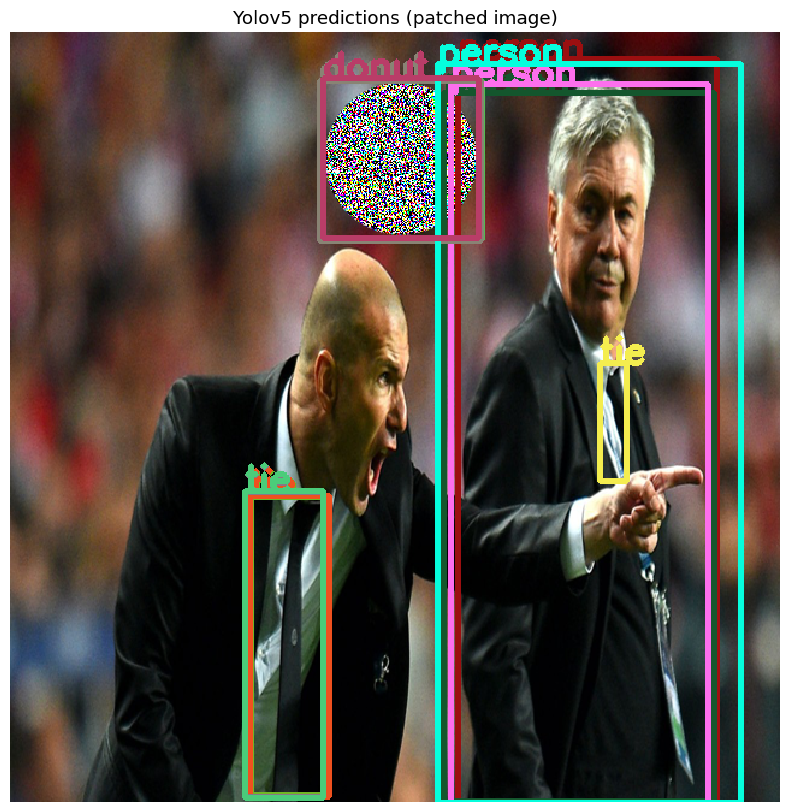

In [27]:
predictions = detector.predict(x=patched_image)[0]


threshold = 0.3
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov5 predictions for patched image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (patched image)")
# Plot predictions
plot_image_with_boxes(img=patched_image[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class) 